In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

import random
from collections import defaultdict

%matplotlib inline

In [2]:
DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness"

In [3]:
YEAR = 2019
raw_tournament_df = pd.read_csv(f"{DATA_DIR}/output/teams.csv")
tournament_df = raw_tournament_df[raw_tournament_df["Season"] == YEAR]
tournament_df

,TeamID,TeamName,Season,OwnScore_Zscore,OppScore_Zscore,Offense,Dominance,OffCompetition,DefCompetition,Competition,Seed,SeedInt,Wins
0,1101,Abilene Chr,2019,-0.021108,-0.375821,-0.396929,0.354714,-0.060151,0.059062,-0.119213,Y15,15,0.0
77,1113,Arizona St,2019,0.540309,-0.020030,0.520279,0.560339,0.044954,-0.041268,0.086222,X11a,11,0.0
113,1120,Auburn,2019,0.668713,-0.330004,0.338709,0.998717,0.086323,-0.080514,0.166837,Y05,5,4.0
133,1124,Baylor,2019,0.171236,-0.367754,-0.196518,0.538990,0.060677,-0.088995,0.149672,X09,9,1.0
141,1125,Belmont,2019,1.075292,-0.026807,1.048486,1.102099,0.007313,0.063784,-0.056471,W11a,11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,1439,Virginia Tech,2019,0.306598,-0.752115,-0.445517,1.058713,0.060724,-0.078557,0.139281,W04,4,2.0
2168,1449,Washington,2019,-0.083146,-0.713522,-0.796668,0.630376,0.046538,-0.044687,0.091225,Y09,9,1.0
2245,1458,Wisconsin,2019,-0.115887,-0.929001,-1.044888,0.813113,0.080123,-0.113615,0.193738,Z05,5,0.0
2250,1459,Wofford,2019,0.598993,-0.527340,0.071653,1.126333,0.047536,0.005411,0.042125,Y07,7,1.0


In [4]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
# Get slots, and order with play ins first
slots_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneySlots.csv")
slots_df = slots_df[slots_df["Season"] == YEAR]
slots_df = pd.concat([
    slots_df[~slots_df["Slot"].str.startswith("R")],
    slots_df[slots_df["Slot"].str.startswith("R")]
])
slots_df

,Season,Slot,StrongSeed,WeakSeed
2247,2019,W11,W11a,W11b
2248,2019,W16,W16a,W16b
2249,2019,X11,X11a,X11b
2250,2019,X16,X16a,X16b
2184,2019,R1W1,W01,W16
...,...,...,...,...
2242,2019,R4Y1,R3Y1,R3Y2
2243,2019,R4Z1,R3Z1,R3Z2
2244,2019,R5WX,R4W1,R4X1
2245,2019,R5YZ,R4Y1,R4Z1


In [5]:
games_df = pd.read_csv(f"{DATA_DIR}/output/games_training.csv")
games_df

,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OppScore_Zscore_A,OffCompetition_A,DefCompetition_A,OwnScore_Zscore_B,OppScore_Zscore_B,OffCompetition_B,DefCompetition_B,Win_A
0,1985,1228,1328,-0.170650,-1.122919,0.071527,-0.070089,1.632782,0.530574,0.074592,-0.030607,True
1,1985,1228,1328,-0.170650,-1.122919,0.071527,-0.070089,1.632782,0.530574,0.074592,-0.030607,True
2,1985,1242,1328,0.428736,-0.163805,0.075843,-0.034858,1.632782,0.530574,0.074592,-0.030607,True
3,1985,1328,1374,1.632782,0.530574,0.074592,-0.030607,0.522222,-0.193731,0.039361,-0.027919,False
4,1985,1328,1409,1.632782,0.530574,0.074592,-0.030607,0.660810,0.046198,0.066972,-0.009949,False
...,...,...,...,...,...,...,...,...,...,...,...,...
166875,2020,1460,1464,0.580601,0.198484,-0.033763,0.061707,-0.105439,0.096059,-0.026838,0.058533,False
166876,2020,1227,1460,-0.313002,-0.164300,-0.023355,0.048164,0.580601,0.198484,-0.033763,0.061707,True
166877,2020,1227,1460,-0.313002,-0.164300,-0.023355,0.048164,0.580601,0.198484,-0.033763,0.061707,True
166878,2020,1232,1460,0.095964,-0.190164,-0.009144,-0.020654,0.580601,0.198484,-0.033763,0.061707,True


In [6]:
# Train predictor based on derived offense and quality metrics
predict_df = games_df[[
    "OwnScore_Zscore_A", "OwnScore_Zscore_B",
    "OppScore_Zscore_A", "OppScore_Zscore_B",   
    "OffCompetition_A", "OffCompetition_B",
    "DefCompetition_A", "DefCompetition_B",    
]]

scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(predict_df),
    columns=predict_df.columns
) 

reg = LogisticRegression().fit(
    data_scaled,
    games_df[["Win_A"]]
)
reg.score(
    data_scaled,
    games_df[["Win_A"]]
), reg.coef_

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.7488374880153403,
 array([[ 0.98057037, -0.97978159, -0.88833934,  0.92578586,  0.38318301,
         -0.36268605, -0.42065262,  0.41671529]]))

In [7]:
# See p-values for model
import statsmodels.api as sm
logit_model=sm.Logit(
    games_df[["Win_A"]].astype(int),
    data_scaled,
)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.496916
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Win_A   No. Observations:               166880
Model:                          Logit   Df Residuals:                   166872
Method:                           MLE   Df Model:                            7
Date:                Sun, 14 Mar 2021   Pseudo R-squ.:                  0.2828
Time:                        09:02:31   Log-Likelihood:                -82925.
converged:                       True   LL-Null:                   -1.1563e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
OwnScore_Zscore_A     0.9797      0.008    124.244      0.000       0.964       0.995
OwnScore

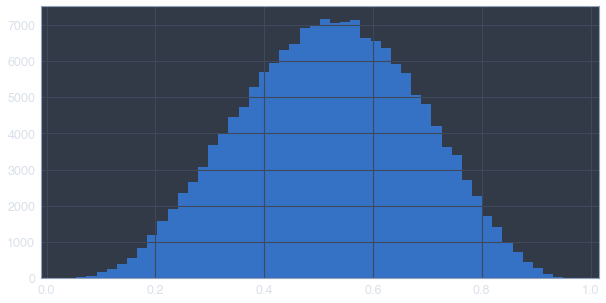

In [8]:
# Sanity check probability distribution
plt.figure(figsize=(10,5));
probs = [
    a for a, b in reg.predict_proba(predict_df)
]
plt.hist(probs, bins=50);

In [9]:
average_team = raw_tournament_df.mean().to_dict()
average_team

{'TeamID': 1291.6819772528434,
 'Season': 2002.2200349956256,
 'OwnScore_Zscore': 0.3844055781106282,
 'OppScore_Zscore': -0.3066529675474941,
 'Offense': 0.07775261056313403,
 'Dominance': 0.6910585456581223,
 'OffCompetition': 0.03172488205590413,
 'DefCompetition': -0.030439737600443127,
 'Competition': 0.06216461965634727,
 'SeedInt': 8.615048118985127,
 'Wins': 0.9645669291338582}

In [10]:
from functools import lru_cache

@lru_cache(maxsize=4096)
def calc_prob(predict_data):
    return reg.predict_proba(scaler.transform([predict_data]))[0][1]

def get_power_rating(team):
    return calc_prob((
            team["OwnScore_Zscore"], average_team["OwnScore_Zscore"],
            team["OppScore_Zscore"], average_team["OppScore_Zscore"],
            team["OffCompetition"], average_team["OffCompetition"],
            team["DefCompetition"], average_team["DefCompetition"],
        ))

In [11]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    offset = 0.01 * (max(x) - min(x))
    for line in range(len(x)):
         p1.text(
             x.iloc[line]+offset, y.iloc[line], 
             labelseries.iloc[line], size=labelsize, color=labelcolor
         )
    return p1

In [12]:
# Best teams of all time
raw_tournament_df["PowerRating"] = raw_tournament_df.apply(get_power_rating, axis=1)
raw_tournament_df["PowerOdds"] = raw_tournament_df["PowerRating"] / (1-raw_tournament_df["PowerRating"])
raw_tournament_df["PowerLogOdds"] = np.log(raw_tournament_df["PowerOdds"])

raw_tournament_df.sort_values(by="PowerRating", ascending=False)[[
    "Season", "TeamName", "Seed", "PowerRating", "Dominance", "Competition", "Wins"
]][:25]

,Season,TeamName,Seed,PowerRating,Dominance,Competition,Wins
419,1999,Duke,W01,0.962798,1.898685,0.165448,5.0
421,2001,Duke,W01,0.959187,1.752481,0.193301,6.0
838,2015,Kentucky,Y01,0.958352,1.931784,0.148082,4.0
418,1998,Duke,Z01,0.958141,1.811089,0.174374,3.0
1284,1998,North Carolina,W01,0.942888,1.608986,0.183083,4.0
1973,1991,UNLV,Z01,0.941933,2.084736,0.062719,4.0
822,1997,Kentucky,Z01,0.941725,1.790978,0.133776,5.0
321,1996,Connecticut,Y01,0.941306,1.662236,0.170850,2.0
680,1992,Indiana,X02,0.938825,1.503301,0.201535,4.0
769,1997,Kansas,X01,0.937842,1.723304,0.142469,2.0


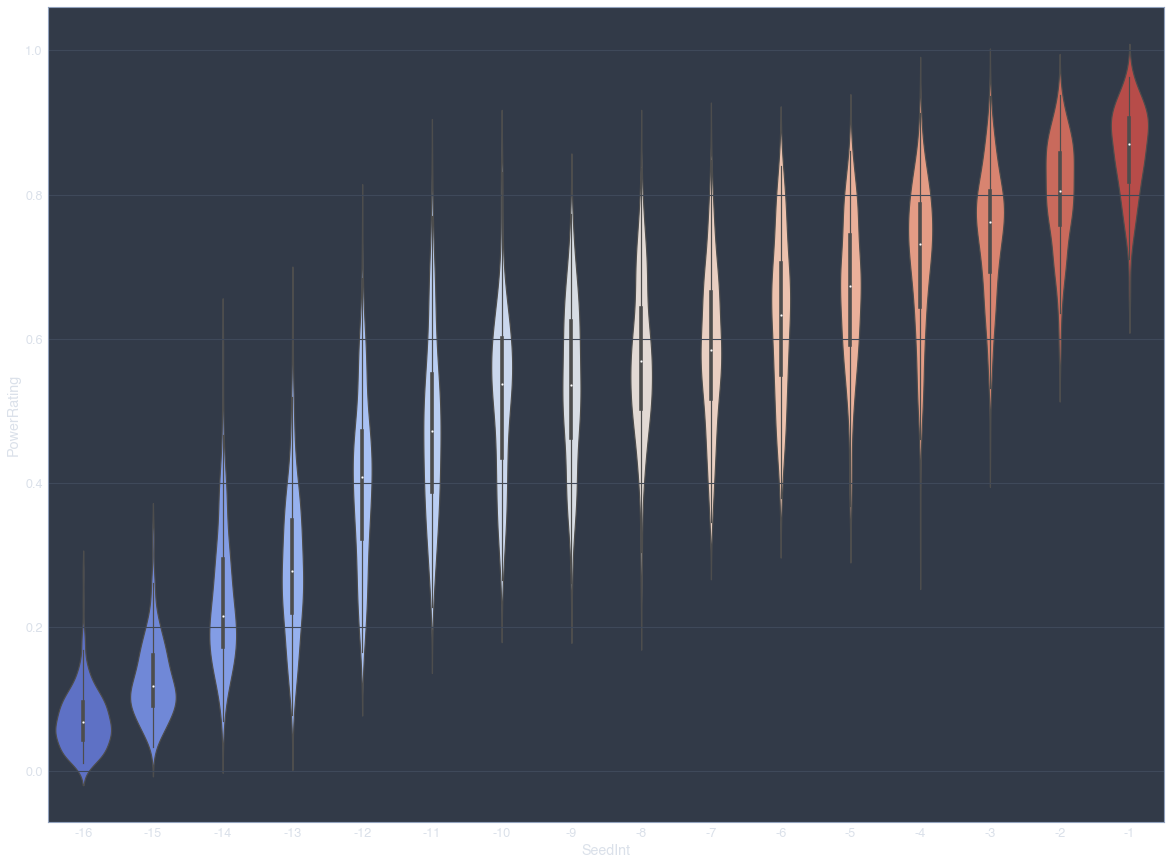

In [13]:
plt.figure(figsize=(20,15));
sns.violinplot(
    x=-raw_tournament_df["SeedInt"],
    y=raw_tournament_df["PowerRating"],
    palette="coolwarm",
);

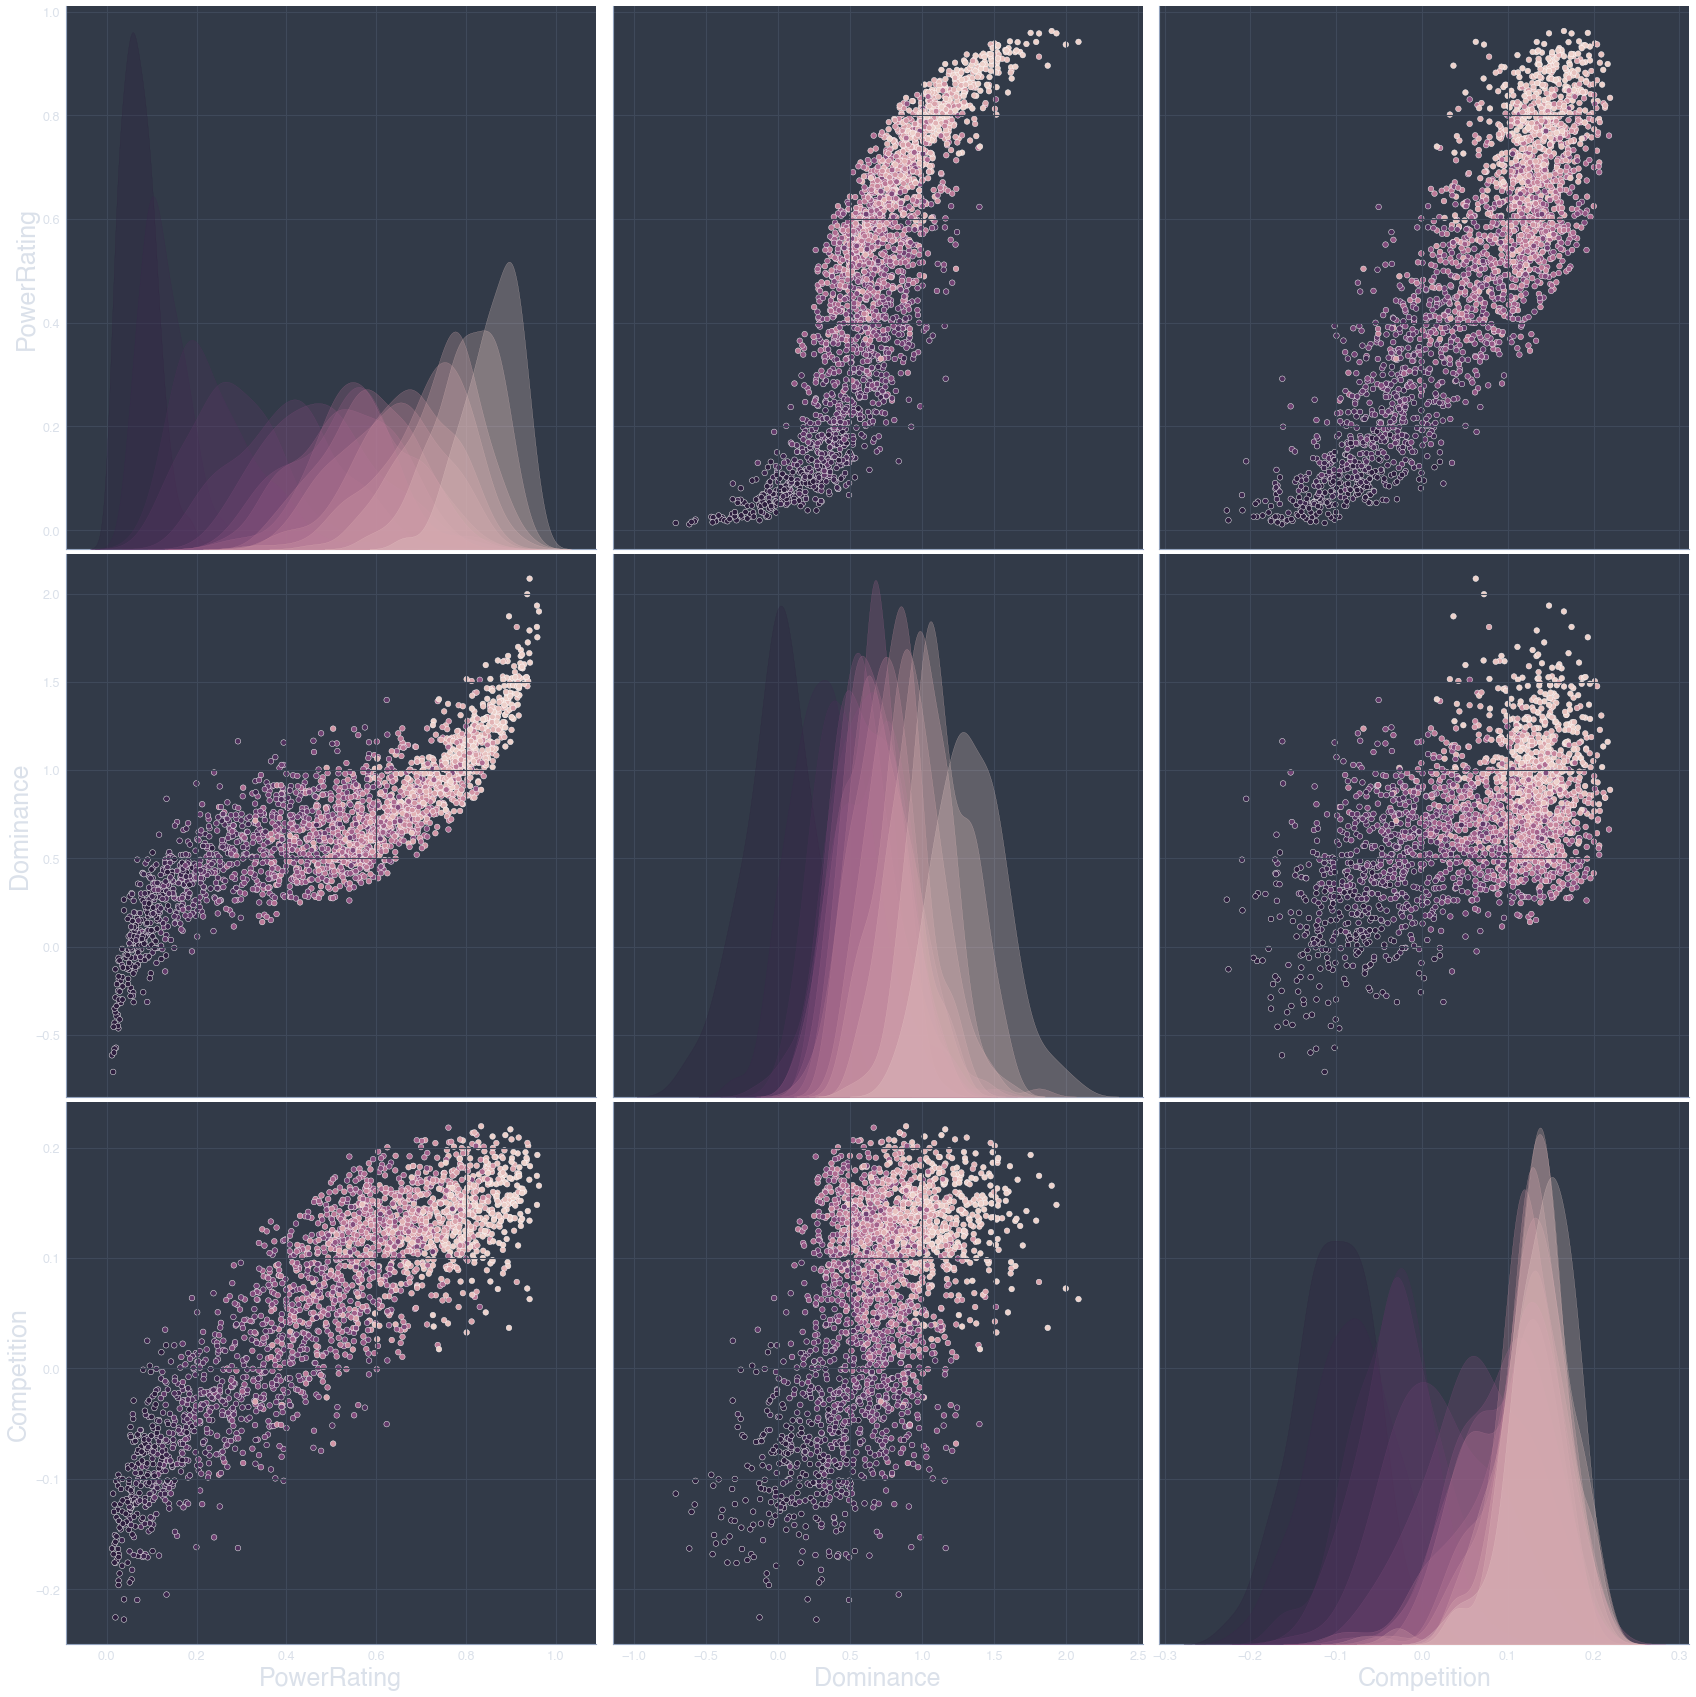

In [14]:
with sns.plotting_context():
    plt.rc('axes', labelsize=25);
    g = sns.pairplot(
        raw_tournament_df[["PowerRating", "Dominance", "Competition", "SeedInt"]],
        hue="SeedInt", height=8
    );
    g._legend.remove();

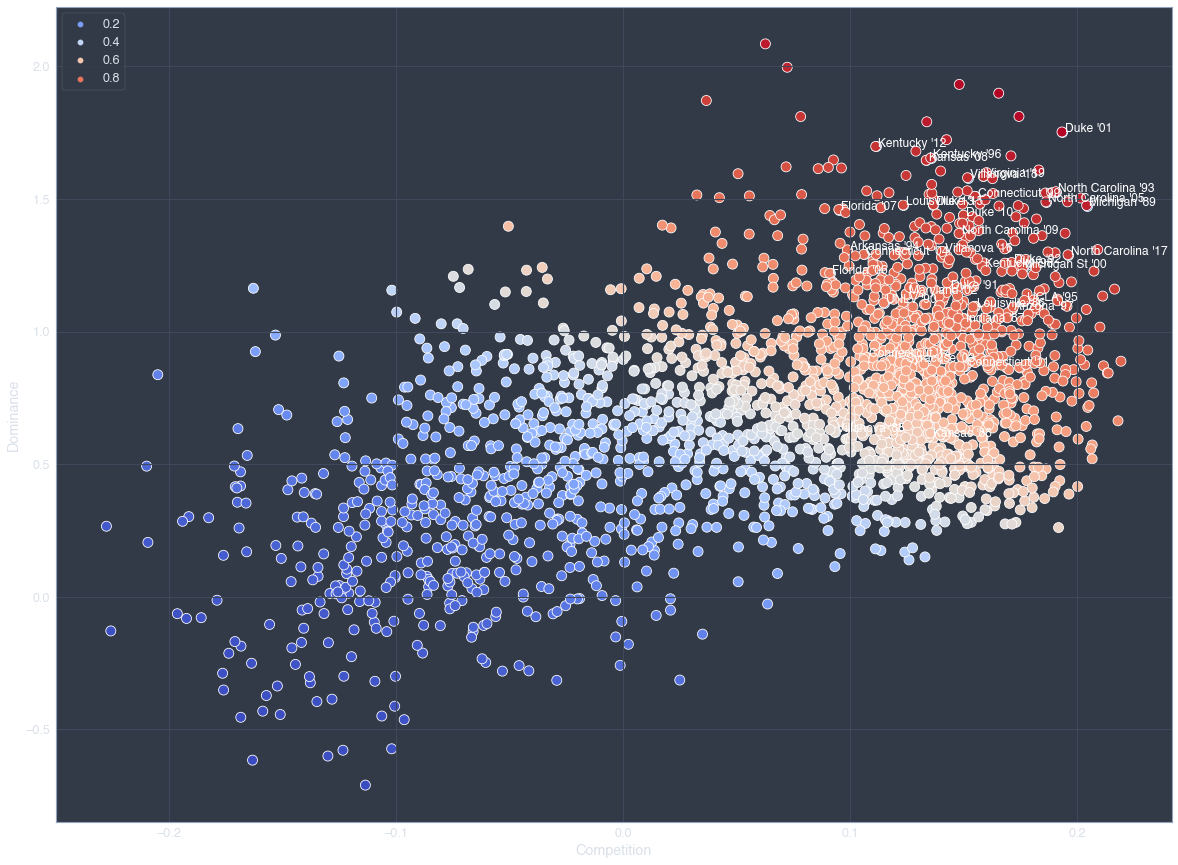

In [15]:
plt.figure(figsize=(20,15));
is_champion = raw_tournament_df["Wins"] >= 6
label_series = (
    raw_tournament_df[is_champion]["TeamName"] + " '" +
    raw_tournament_df[is_champion]["Season"].astype(str).str[-2:]
)
scatter_text(
    x=raw_tournament_df[is_champion]["Competition"],
    y=raw_tournament_df[is_champion]["Dominance"],
    labelseries=label_series,
    labelcolor="white",
    s=100,
);
sns.scatterplot(
    x=raw_tournament_df["Competition"],
    y=raw_tournament_df["Dominance"],
    hue=raw_tournament_df["PowerRating"],
    palette=sns.color_palette("coolwarm", as_cmap=True),
    s=100,
);
plt.legend(loc='upper left');

In [16]:
power_ratings = {}
slots_wins = defaultdict(lambda: defaultdict(int))
total_stats = defaultdict(lambda: defaultdict(int))
simulation_progression = []
random.seed(19910416)

SIMULATION_ROUNDS = 10000
SIM_MOD = SIMULATION_ROUNDS / 10
TOP_N = 5
for i in tqdm(range(SIMULATION_ROUNDS)):
    # INITIALIZE BRACKET (will be updated durign simulation)
    slots_dict = {
        row["Seed"]: row
        for _, row in tournament_df.iterrows()
    }
    
    for _, r in slots_df.iterrows():
        team_a = slots_dict[r["StrongSeed"]]
        team_b = slots_dict[r["WeakSeed"]]
        predict_data = (
            team_a["OwnScore_Zscore"], team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"], team_b["OppScore_Zscore"],
            team_a["OffCompetition"], team_b["OffCompetition"],
            team_a["DefCompetition"], team_b["DefCompetition"],
        )
        prob = calc_prob(predict_data)
        winning_team = team_a if random.random() < prob else team_b
        slots_dict[r["Slot"]] = winning_team
        slots_wins[r["Slot"]][winning_team["TeamID"]] += 1
        total_stats[winning_team["TeamID"]]["wins"] += 1
        if r["Slot"][1] == "3":
            total_stats[winning_team["TeamID"]]["elite8"] += 1
        if r["Slot"][1] == "4":
            total_stats[winning_team["TeamID"]]["final4"] += 1
        
        # Get "difficulty" by looking at opposing power ratings
        power_a = get_power_rating(team_a)
        power_ratings[team_a["TeamID"]] = power_a
        total_stats[team_b["TeamID"]]["opp_power"] += power_a
        total_stats[team_b["TeamID"]]["opp_power_count"] += 1
        
        power_b = get_power_rating(team_b)
        power_ratings[team_b["TeamID"]] = power_b
        total_stats[team_a["TeamID"]]["opp_power"] += power_b
        total_stats[team_a["TeamID"]]["opp_power_count"] += 1
    
    # last winning team is champion
    total_stats[winning_team["TeamID"]]["championships"] +=1
    
    # Track top teams
    if (len(total_stats) > TOP_N) and ((i + 1) % SIM_MOD == 0):
        teams_by_championships = sorted(
            total_stats.items(), key=lambda x: x[1]["championships"], reverse=True
        )
        for team_id, stats in teams_by_championships[:TOP_N]:
            simulation_progression.append({
                "TeamID": team_id,
                "PercentChampion": stats["championships"] / (i + 1),
                "Rounds": i + 1
            })

100%|██████████| 10000/10000 [01:29<00:00, 111.20it/s]


In [17]:
power_df = pd.DataFrame([{"TeamID": k, "PowerRating": v} for k, v in power_ratings.items()])
tournament_df = tournament_df.merge(power_df, on="TeamID")

In [18]:
simulation_df = pd.DataFrame([
    {
        "TeamID": team_id,
        "AvgOppPower": results_dict["opp_power"] / results_dict["opp_power_count"],
        "MeanWins": results_dict["wins"] / SIMULATION_ROUNDS,
        "PercentElite8": results_dict["elite8"] / SIMULATION_ROUNDS,
        "PercentFinal4": results_dict["final4"] / SIMULATION_ROUNDS,
        "PercentChampion": results_dict["championships"] / SIMULATION_ROUNDS,
    }
    for team_id, results_dict in total_stats.items()
])
simulation_df = simulation_df.merge(tournament_df, on="TeamID")[[
    "TeamID", "TeamName", "Seed", "SeedInt",
    "OwnScore_Zscore",
    "OppScore_Zscore",
    "Offense",
    "Dominance",
    "Competition",
    "AvgOppPower",
    "PowerRating",
    "MeanWins",
    "PercentElite8",
    "PercentFinal4",
    "PercentChampion",
]]
simulation_df["FairMoneyChampion"] = round(
    100 * (1 - simulation_df["PercentChampion"]) / simulation_df["PercentChampion"]
)

In [19]:
simulation_df["LogOdds"] = np.log(
    simulation_df["PercentChampion"] / (1-simulation_df["PercentChampion"])
).replace([np.inf, -np.inf], np.nan)
simulation_df["LogOdds"] = simulation_df["LogOdds"].fillna(simulation_df["LogOdds"].min())

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


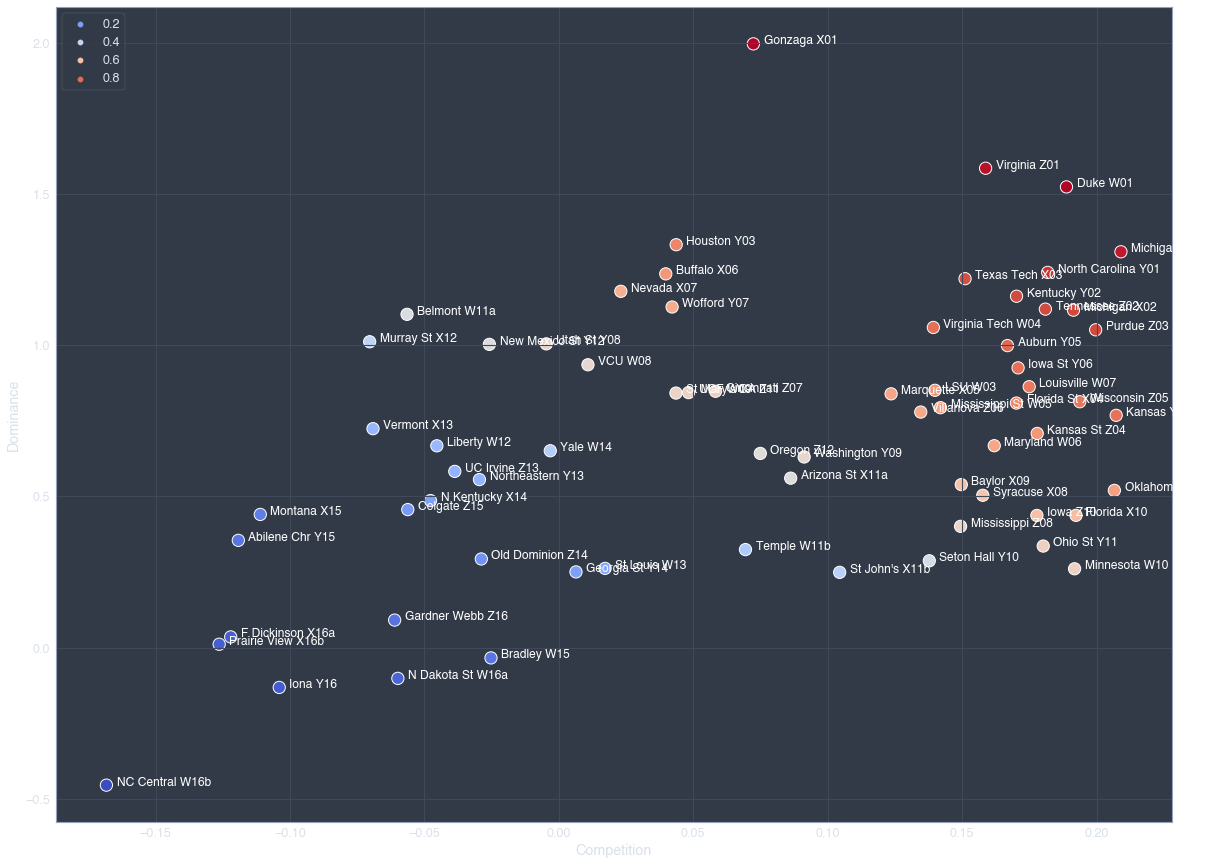

In [20]:
plt.figure(figsize=(20,15));
scatter_text(
    x=simulation_df["Competition"], y=simulation_df["Dominance"], s=150,
    hue=simulation_df["PowerRating"],
    palette=sns.color_palette("coolwarm", as_cmap=True),
    labelseries=simulation_df["TeamName"] + " " + simulation_df["Seed"],
    labelcolor="white",
);
plt.legend(loc='upper left');

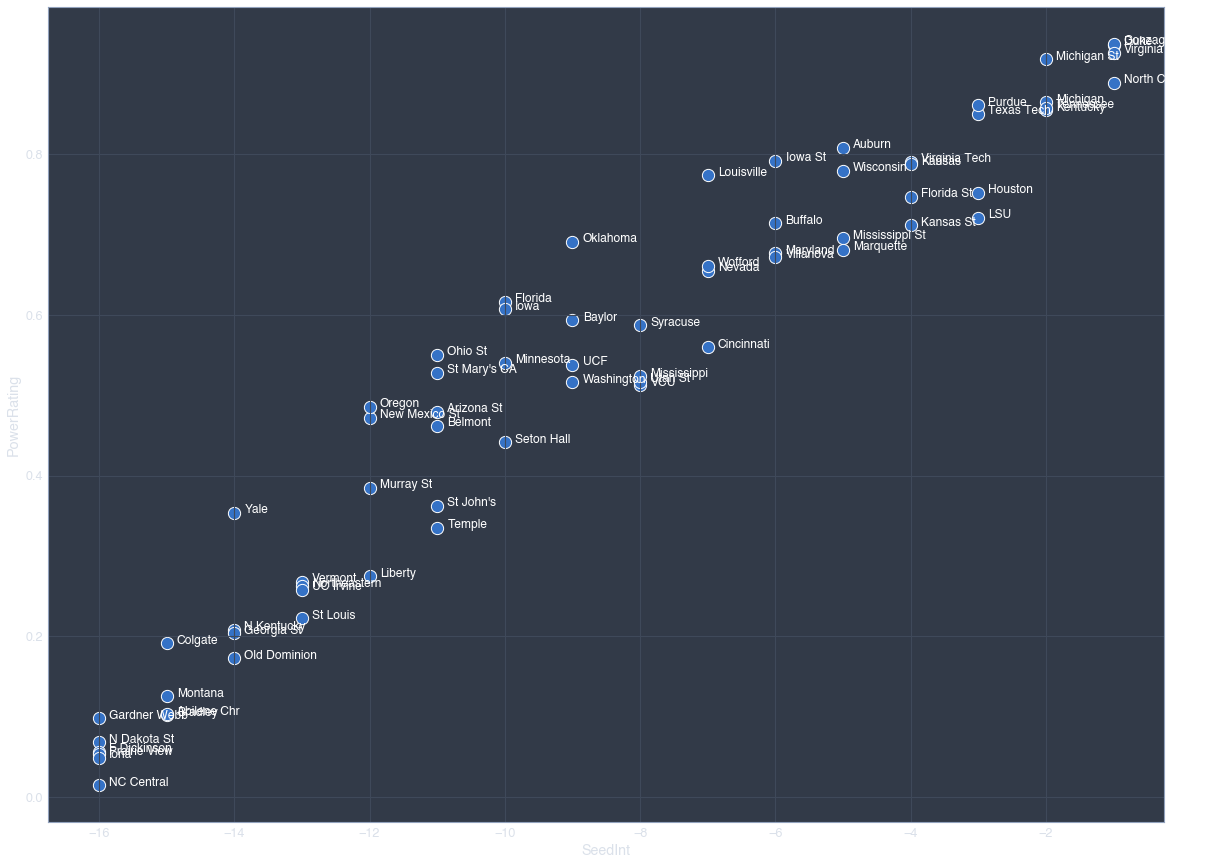

In [21]:
plt.figure(figsize=(20,15));
scatter_text(
    x=-simulation_df["SeedInt"],
    y=simulation_df["PowerRating"],
    s=150, labelseries=simulation_df["TeamName"], labelcolor="white",
);

In [22]:
BASIC_COLUMNS = [
    "TeamName", "Seed", "MeanWins",
    "PercentElite8", "PercentFinal4", "PercentChampion", "FairMoneyChampion"
]

In [23]:
# Who is the best team?
simulation_df.sort_values("PowerRating", ascending=False)[["PowerRating"] + BASIC_COLUMNS][:30]

,PowerRating,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion,FairMoneyChampion
22,0.936665,Gonzaga,X01,3.8238,0.7853,0.5746,0.2163,362.0
8,0.935826,Duke,W01,3.6697,0.7635,0.4967,0.1969,408.0
52,0.925324,Virginia,Z01,3.5629,0.7028,0.4855,0.1810,452.0
9,0.917641,Michigan St,W02,3.1053,0.6704,0.3558,0.1102,807.0
36,0.887963,North Carolina,Y01,3.1051,0.5922,0.3773,0.0768,1202.0
23,0.863944,Michigan,X02,2.4662,0.4474,0.1766,0.0301,3222.0
56,0.860144,Purdue,Z03,2.5037,0.4437,0.1942,0.0381,2525.0
54,0.857038,Tennessee,Z02,2.4754,0.4251,0.1897,0.0352,2741.0
38,0.854110,Kentucky,Y02,2.6389,0.4950,0.2533,0.0378,2546.0
25,0.849732,Texas Tech,X03,2.2485,0.3825,0.1433,0.0200,4900.0


In [24]:
# Who has the easiest schedule on average (excluding play ins)
is_not_play_in =  ~simulation_df["Seed"].str[-1].apply(str.isalpha)
simulation_df[is_not_play_in].sort_values(
    "AvgOppPower", ascending=True)[["AvgOppPower"] + BASIC_COLUMNS][:16]

,AvgOppPower,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion,FairMoneyChampion
36,0.549854,North Carolina,Y01,3.1051,0.5922,0.3773,0.0768,1202.0
38,0.554257,Kentucky,Y02,2.6389,0.4950,0.2533,0.0378,2546.0
40,0.558430,Houston,Y03,1.6702,0.1925,0.0694,0.0046,21639.0
27,0.559422,Florida St,X04,1.6196,0.1157,0.0464,0.0030,33233.0
58,0.560869,Kansas St,Z04,1.4105,0.0889,0.0280,0.0013,76823.0
13,0.563971,Virginia Tech,W04,1.7742,0.1499,0.0552,0.0068,14606.0
15,0.572110,Mississippi St,W05,1.3031,0.0661,0.0178,0.0009,111011.0
23,0.574182,Michigan,X02,2.4662,0.4474,0.1766,0.0301,3222.0
54,0.576874,Tennessee,Z02,2.4754,0.4251,0.1897,0.0352,2741.0
11,0.577004,LSU,W03,1.4594,0.1182,0.0242,0.0013,76823.0


In [25]:
# Who has the best chance to win
pie_df = simulation_df.sort_values("PercentChampion", ascending=False)
pie_df[[
    "TeamName", "Seed", "PowerRating", "AvgOppPower",
    "PercentElite8", "PercentFinal4", "PercentChampion", "FairMoneyChampion"
]][:10]

,TeamName,Seed,PowerRating,AvgOppPower,PercentElite8,PercentFinal4,PercentChampion,FairMoneyChampion
22,Gonzaga,X01,0.936665,0.594084,0.7853,0.5746,0.2163,362.0
8,Duke,W01,0.935826,0.584152,0.7635,0.4967,0.1969,408.0
52,Virginia,Z01,0.925324,0.603808,0.7028,0.4855,0.1810,452.0
9,Michigan St,W02,0.917641,0.602515,0.6704,0.3558,0.1102,807.0
36,North Carolina,Y01,0.887963,0.549854,0.5922,0.3773,0.0768,1202.0
56,Purdue,Z03,0.860144,0.580319,0.4437,0.1942,0.0381,2525.0
38,Kentucky,Y02,0.854110,0.554257,0.4950,0.2533,0.0378,2546.0
54,Tennessee,Z02,0.857038,0.576874,0.4251,0.1897,0.0352,2741.0
23,Michigan,X02,0.863944,0.574182,0.4474,0.1766,0.0301,3222.0
25,Texas Tech,X03,0.849732,0.589511,0.3825,0.1433,0.0200,4900.0


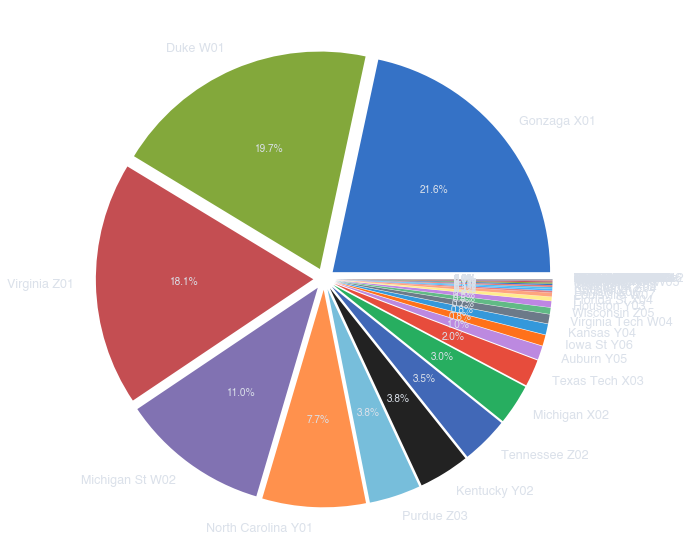

In [26]:
plt.figure(figsize=(10,10));
plt.pie(
    x=pie_df["PercentChampion"],
    labels=pie_df["TeamName"] + " " + pie_df["Seed"],
    autopct="%.1f%%",
    explode=[0.05]*len(simulation_df),
);

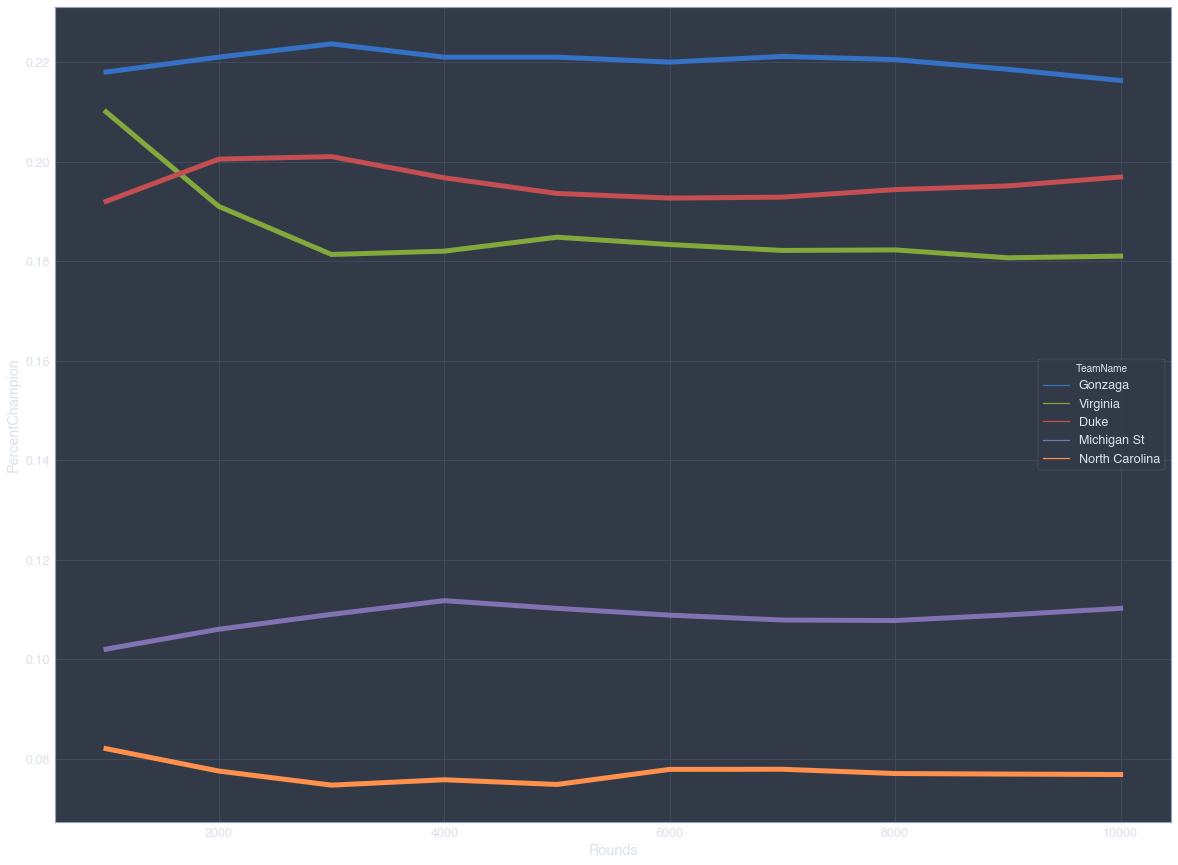

In [27]:
# Confirm % looks stable over time
plt.figure(figsize=(20,15));
progression_df = pd.DataFrame(simulation_progression).merge(
    tournament_df[["TeamID", "TeamName"]], on="TeamID"
)
sns.lineplot(
    data=progression_df,
    x="Rounds", y="PercentChampion", hue="TeamName", linewidth=5
);

In [28]:
 # What is the most common bracket?
bracket_slots = []
for slot, win_dict in slots_wins.items():
    top_teams = sorted(((v, k) for k, v in win_dict.items()), reverse=True)
    max_count, max_team_id = top_teams[0]
    runner_count, runner_team_id = top_teams[1]
    total = sum(v for v in win_dict.values())
    bracket_slots.append({
        "Slot": slot,
        "WinTeamID": max_team_id,
        "WinPct": max_count / total,
        "RunnerTeamID": runner_team_id,
        "RunnerWinPct": runner_count / total,
    })

bracket_df = pd.DataFrame(bracket_slots).merge(
    tournament_df[["TeamID", "TeamName", "Seed"]], left_on="WinTeamID", right_on="TeamID"
).rename(columns={"TeamName": "WinTeamName", "Seed": "WinSeed"}).merge(
    tournament_df[["TeamID", "TeamName", "Seed"]], left_on="RunnerTeamID", right_on="TeamID"
).rename(columns={"TeamName": "RunnerTeamName", "Seed": "RunnerSeed"})
bracket_df["Round"] = bracket_df["Slot"].apply(lambda x: int(x[1]) if x.startswith("R") else 0)
bracket_df = bracket_df[[
    "Slot", "Round",
    "WinTeamName", "WinSeed", "WinPct",
    "RunnerTeamName", "RunnerSeed", "RunnerWinPct"
]]

In [29]:
bracket_df[bracket_df["Round"] == 5].sort_values("WinPct", ascending=False)

,Slot,Round,WinTeamName,WinSeed,WinPct,RunnerTeamName,RunnerSeed,RunnerWinPct
55,R5YZ,5,Virginia,Z01,0.3398,North Carolina,Y01,0.1881
23,R5WX,5,Gonzaga,X01,0.3390,Duke,W01,0.2931


In [30]:
# Submit to Kaggle
import itertools
predictions = []
vegas = []
for year in range(2015, 2020):
    submit_df = raw_tournament_df[raw_tournament_df["Season"] == year].set_index(["Season", "TeamID"])
    ids = sorted(submit_df.loc[year].index)
    for id_a, id_b in itertools.product(ids, ids):
        if id_a >= id_b:
            continue
        team_a = submit_df.loc[(year, id_a)]
        team_b = submit_df.loc[(year, id_b)]
        predict_data = (
            team_a["OwnScore_Zscore"], team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"], team_b["OppScore_Zscore"],
            team_a["OffCompetition"], team_b["OffCompetition"],
            team_a["DefCompetition"], team_b["DefCompetition"],
        )
        prob = calc_prob(predict_data)
        predictions.append({
            "ID": f"{year}_{id_a}_{id_b}",
            "Pred": prob
        })
        if year == YEAR:
            favorite = team_a["TeamName"] if prob > .5 else team_b["TeamName"]
            prob = max(prob, 1 - prob)
            vegas.append({
                "TeamA": team_a["TeamName"],
                "TeamB": team_b["TeamName"],
                "Favorite": favorite,
                "Prob": prob,
                "FairMoney": round(100 * prob / (1 - prob)),
            })

In [31]:
pred_df = pd.DataFrame(predictions)
pred_df.to_csv(f"{DATA_DIR}/output/kaggle_submission.csv", index=False)

In [32]:
vegas_df = pd.DataFrame(vegas).set_index(["TeamA", "TeamB"])

In [33]:
set(vegas_df.index.get_level_values(0))

{'Abilene Chr',
 'Arizona St',
 'Auburn',
 'Baylor',
 'Belmont',
 'Bradley',
 'Buffalo',
 'Cincinnati',
 'Colgate',
 'Duke',
 'F Dickinson',
 'Florida',
 'Florida St',
 'Gardner Webb',
 'Georgia St',
 'Gonzaga',
 'Houston',
 'Iona',
 'Iowa',
 'Iowa St',
 'Kansas',
 'Kansas St',
 'Kentucky',
 'LSU',
 'Liberty',
 'Louisville',
 'Marquette',
 'Maryland',
 'Michigan',
 'Michigan St',
 'Minnesota',
 'Mississippi',
 'Mississippi St',
 'Montana',
 'Murray St',
 'N Dakota St',
 'N Kentucky',
 'NC Central',
 'Nevada',
 'New Mexico St',
 'North Carolina',
 'Northeastern',
 'Ohio St',
 'Oklahoma',
 'Old Dominion',
 'Oregon',
 'Prairie View',
 'Purdue',
 'Seton Hall',
 "St John's",
 'St Louis',
 "St Mary's CA",
 'Syracuse',
 'Temple',
 'Tennessee',
 'Texas Tech',
 'UC Irvine',
 'UCF',
 'Utah St',
 'VCU',
 'Vermont',
 'Villanova',
 'Virginia',
 'Virginia Tech',
 'Washington',
 'Wisconsin',
 'Wofford'}

In [34]:
vegas_df.loc[("Duke", "UCF")]

Favorite         Duke
Prob         0.923822
FairMoney        1213
Name: (Duke, UCF), dtype: object